# Série 11 - Exercices - Solutions

Dans cette série d'exercice, on reprend les exemples traités lors de la série précédente, mais on complète le travail en estimant l'incertitude sur les paramètres du modèle.


**Exercice 1** - Incertitude sur l'âge du système solaire

On a  :
- Le fichier `eucrites.txt` contient en première colonne contient le rapport isotopique 87Rb/86Sr et en deuxième colonne le rapport 87Sr/86Sr.
- On note $a$ la pente de la droite de régression
- La constante de désintégration du Rubidium 87 vaut $\lambda = 1.393 \times 10^{-11} an^{-1}$
- L'âge  s'obtient avec $t =\frac{ \log( a + 1)}{\lambda} $.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Application directe de la propagation d'incertitude sur un système linéaire. Le résultat final est la matrice de covariance des paramètres $C_p$

In [5]:
data = np.loadtxt('data/eucrites.txt')
xd, yd = data[:,0], data[:,1]

G = np.ones( (len(xd), 2) ) # Construction de la matrice G
G[:,0] = xd       
p = np.linalg.inv( G.T @ G ) @  G.T @ yd # Pseudo inverse pour trouver p

e = G @ p - yd  # Vecteur des erreurs
var_e = np.var(e, ddof=2) # Variance des erreurs

Cp = var_e * np.linalg.inv( G.T @ G ) # Matrice de covariance des paramètres

A partir de la pente optimale $p[0]$ et de la variance obtenue dans la matrice de covariance, on simule 200 valeurs de pente $a$ et on calcule les âges $t$ correspondant, en milliards d'années. On déduit de ces simulations de Monte-Carlos les intervalles de confiance à 95%.

In [4]:
l = 1.393e-11 # Constante de désintégration radioactive

topt = np.log(p[0] + 1) / l / 1e9 # A partir de la valeur optimale

# Simulation pour le calcul d'incertitude
a = np.random.normal(p[0], np.sqrt( Cp[0,0] ), 200)
t = np.log(a+1) / l / 1e9

tmin = np.percentile(t,2.5) # L'intervalle de confiance
tmax = np.percentile(t,97.5)

print(f"L'âge moyen estimé est de {topt:5.3f} milliards d'années")
print(f"Intervalle de confiance à 95% : {tmin:5.3f} - {tmax:5.3f}")

L'âge moyen estimé est de 4.536 milliards d'années
Intervalle de confiance à 95% : 4.383 - 4.710


**Exercice 2** - Graphe avec intervalle de confiance

Faire le graphe correspondant aux données d'Eucrites en représentant l'intervalle de confiance sur la droite estimée.

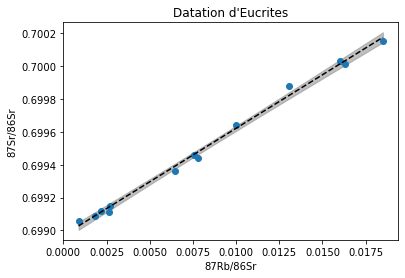

In [6]:
# Choix des valeurs de x pour la figure
xplt = np.linspace(min(xd),max(xd))

# Matrice G du modèle linéaire pour les points choisis
G = np.ones( (len(xplt), 2) )
G[:,0] = xplt

# Covariance des y connaissant la covariance des paramètres
Cy = G @ Cp @ G.T

# Ecart-type de y 
sy = np.sqrt( np.diag(Cy) )
ye = p[0] * xplt + p[1]

# Intervalle à 95%
ymin = ye - 2 * sy
ymax = ye + 2 * sy

# Graphe
plt.plot(xd, yd, 'o')
plt.plot(xplt, ye, 'k--')
plt.fill_between(xplt, ymin, ymax, color="grey", alpha=0.5)
plt.xlabel('87Rb/86Sr')
plt.ylabel('87Sr/86Sr')
plt.title("Datation d'Eucrites")
plt.show()

**Exercice 3** - Régression non linéaire

Nous reprenons maintenant l'exemple de la population de bactérie. Le code ci-dessous refait les étapes de la semaine dernière. Il calcule par la méthode des moindres carrés dans le cas non linéaire, le vecteur de paramètre optimal p, mais renvoie également la covariance des paramètres $C_p$

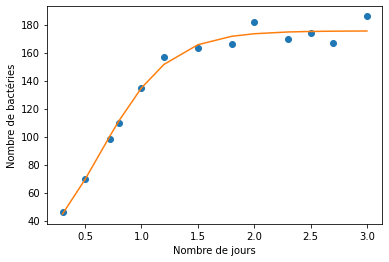

In [7]:
from scipy import optimize

# La fonction logistique
def logistique(t, n0, nmax, r):
    c = (nmax - n0) / n0
    return nmax / (1 + c * np.exp(-r * t))

# Les données
t = np.array((0.3,0.5,0.72,0.8,1,1.2,1.5,1.8,2,2.3,2.5,2.7,3)) # Temps en jours
n = np.array((46,70,98,110,135,157,163,166,182,170,174,167,186)) # Nombres de bactéries

# Optimisation non linéaire pour identifier les paramètres du modèle
p, Cp = optimize.curve_fit(logistique, t, n, p0=[10, 180, 2])

# Représentation du résultat
yc = logistique(t, *p)
plt.plot(t,n,'o')
plt.plot(t,yc,'-')
plt.ylabel('Nombre de bactéries')
plt.xlabel('Nombre de jours')
plt.show()

Que valent les intervalles de confiance sur chacun des paramètres ? **Etendre le code ci-dessous pour afficher ces intervalles de confiance**.

In [9]:
# On extrait simplement la diagonal et calcule l'écart-type
sp = np.sqrt( np.diag(Cp) )

# Impression du résultat
name_param = ["pop. initiale", "pop. maximale", "taux de croissance"]
print("Paramètres identifiés:")
for i in range(len(p)):
    print(f" {name_param[i]:20s} : {p[i]:6.2f},", end='')
    print(f"  Int. Conf. = {p[i]-2*sp[i]:6.2f} / {p[i]+2*sp[i]:6.2f}")

Paramètres identifiés:
 pop. initiale        :  20.10,  Int. Conf. =  12.88 /  27.33
 pop. maximale        : 175.54,  Int. Conf. = 170.38 / 180.70
 taux de croissance   :   3.24,  Int. Conf. =   2.66 /   3.82


**Exercice 4** - Graphe avec intervalle de confiance

Utiliser un ensemble de simulations sur les paramètres pour calculer et représenter l'intervalle de confiance sur le nombre de bactérie en fonction du temps.

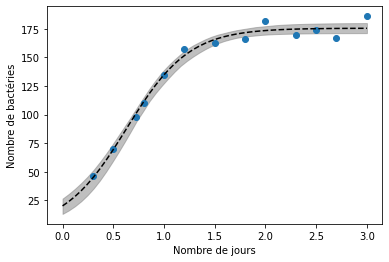

In [10]:
# Choix des temps pour le calcul et représentation sur le graphe
tplot = np.linspace(0,3)

# Le modèle optimal obtenu par la régression
yopt = logistique(tplot, *p)

# On simule des jeux de paramètres compatibles avec Cp
nsim = 100
psim = np.random.multivariate_normal(p, Cp, nsim)

# Matrice pour stocker les résultats
yplot = np.zeros( (nsim, len(tplot)) )
# Simulations de Monte-Carlo
for i in range(len(psim)):
    yplot[i,:] = logistique(tplot, *psim[i,:])

# Calcul des intervalles de confiance à 95%
ymin = np.percentile(yplot, 2.5, axis=0)
ymax = np.percentile(yplot, 97.5, axis=0)

# Graphe
plt.plot(t, n, 'o')
plt.plot(tplot, yopt, 'k--')
plt.fill_between(tplot, ymin, ymax, color='grey', alpha=0.5)
plt.ylabel('Nombre de bactéries')
plt.xlabel('Nombre de jours')
plt.show()    